# 第二模型训练（回归/分类）

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

模型路径：
1. 通过简单的决策树分类出确定的0
2. 然后通过mlp对较为均衡的数据集再进行学习

In [28]:
# 构建 MLP 模型
def build_mlp_ecg(input_length, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_length,)),

        # 第一层
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # 第二层
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # 第三层
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # 输出层
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
# read data frame
# === 加载 MIT-BIH (5类) ===
mitbih_test = pd.read_csv("../data/ecg_category/mitbih_test.csv")
mitbih_train = pd.read_csv("../data/ecg_category/mitbih_train.csv")

X_mitbih_train, y_mitbih_train = mitbih_train.iloc[:, :-1].values, mitbih_train.iloc[:, -1].values
X_mitbih_test, y_mitbih_test = mitbih_test.iloc[:, :-1].values, mitbih_test.iloc[:, -1].values

In [31]:
# === 检查标签分布 ===
print("训练集标签分布：")
print(pd.Series(y_mitbih_train).value_counts())

print("\n测试集标签分布：")
print(pd.Series(y_mitbih_test).value_counts())

# === 检查标签类型 ===
print("\ny_mitbih_train dtype:", y_mitbih_train.dtype)
print("y_mitbih_train unique values:", np.unique(y_mitbih_train)[:10])
print("y_mitbih_test unique values:", np.unique(y_mitbih_test)[:10])

# === 强制转 int，避免 float/NaN ===
y_mitbih_train = y_mitbih_train.astype(int)
y_mitbih_test = y_mitbih_test.astype(int)

训练集标签分布：
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

测试集标签分布：
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

y_mitbih_train dtype: float64
y_mitbih_train unique values: [0. 1. 2. 3. 4.]
y_mitbih_test unique values: [0. 1. 2. 3. 4.]


In [32]:
# 1) 训练集上用决策树筛“易例 0”
import numpy as np
from sklearn.tree import DecisionTreeClassifier

# 假设已有 X_train, y_train (标签为 0..4 的整数)
tree = DecisionTreeClassifier(
    max_depth=21,            # 浅一点，避免过拟合
    min_samples_leaf=20,    # 提高叶子样本量，稳一些
    class_weight='balanced',
    random_state=42
)
tree.fit(X_mitbih_train, y_mitbih_train)

# 预测 P(y=0|x)
p0 = tree.predict_proba(X_mitbih_train)[:, 0]

tau = 0.95  # 训练阶段阈值（可用验证集调参）
is_easy_zero = (y_mitbih_train == 0) & (p0 >= tau)

# 可选：限制最多剔除的数量，避免过头
easy_zero_idx = np.where(is_easy_zero)[0]

# 构建“难例训练集”：保留所有少数类 + 难例0
keep_mask = np.ones_like(y_mitbih_train, dtype=bool)
keep_mask[easy_zero_idx] = False
X_train_hard = X_mitbih_train[keep_mask]
y_train_hard = y_mitbih_train[keep_mask]

print("原训练集大小:", len(y_mitbih_train), "筛后训练集大小:", len(y_train_hard))
unique, counts = np.unique(y_train_hard, return_counts=True)
print("筛后类别分布:", dict(zip(unique, counts)))


原训练集大小: 87553 筛后训练集大小: 24479
筛后类别分布: {0: 9396, 1: 2223, 2: 5788, 3: 641, 4: 6431}


In [33]:
# 1) 确认 predict_proba 列顺序
print("classes_ =", tree.classes_)   # 应为 [0,1,2,3,4]
p = tree.predict_proba(X_mitbih_train)      # shape: (N, 5)
p0 = p[:, list(tree.classes_).index(0)]

# 2) 看一下 p0 的分布
import numpy as np
q = np.quantile(p0, [0, .5, .9, .95, .98, .99, .995, 1.0])
print("p0 quantiles:", q)

# 3) 看一下在真0类里的 p0
q0 = np.quantile(p0[y_mitbih_train==0], [0, .5, .9, .95, .98, .99, .995, 1.0])
print("p0 | y=0 quantiles:", q0)

# 4) 也看一下非0类里被“高p0”覆盖多少
for t in [0.95, 0.98, 0.99]:
    tp = np.mean((p0>=t) & (y_mitbih_train==0))
    fp = np.mean((p0>=t) & (y_mitbih_train!=0))
    print(f"tau={t}: 训练集里 高p0比例，总={np.mean(p0>=t):.4f}, 真0占比={tp:.4f}, 误杀非0占比={fp:.4f}")


classes_ = [0 1 2 3 4]
p0 quantiles: [0. 1. 1. 1. 1. 1. 1. 1.]
p0 | y=0 quantiles: [1.13737725e-04 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]
tau=0.95: 训练集里 高p0比例，总=0.7205, 真0占比=0.7204, 误杀非0占比=0.0001
tau=0.98: 训练集里 高p0比例，总=0.6881, 真0占比=0.6881, 误杀非0占比=0.0000
tau=0.99: 训练集里 高p0比例，总=0.6881, 真0占比=0.6881, 误杀非0占比=0.0000


In [34]:
# class_weight（基于筛后训练集）
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import numpy as np


cls_w = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.arange(5),
    y=y_train_hard
)
cls_w = {i: w for i, w in enumerate(cls_w)}

# 一个稳健的 MLP
import tensorflow as tf
inputs = tf.keras.Input(shape=(X_train_hard.shape[1],))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
mlp = tf.keras.Model(inputs, outputs)

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

cb = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# 假设你已经得到筛后的：
# X_train_hard, y_train_hard
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_hard, y_train_hard,
    test_size=0.15,           # 15% 做验证
    random_state=42,
    stratify=y_train_hard     # 保持类别比例
)

# === 添加在这里 ===
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_mitbih_test = scaler.transform(X_mitbih_test)  # 若之后还要用测试集预测，也提前标准化
# === 到此结束 ===

# 然后把 fit 里的变量换成：
mlp.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=60, batch_size=256,
    class_weight=cls_w,
    callbacks=cb,
    verbose=1
)


Epoch 1/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5165 - loss: 1.1666 - val_accuracy: 0.5839 - val_loss: 1.2415 - learning_rate: 0.0010
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5641 - loss: 0.9717 - val_accuracy: 0.6119 - val_loss: 1.0885 - learning_rate: 0.0010
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5698 - loss: 0.9263 - val_accuracy: 0.6032 - val_loss: 1.0353 - learning_rate: 0.0010
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5786 - loss: 0.8938 - val_accuracy: 0.5896 - val_loss: 1.0488 - learning_rate: 0.0010
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5857 - loss: 0.8963 - val_accuracy: 0.5724 - val_loss: 1.0401 - learning_rate: 0.0010
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5885 - loss: 0.8807 - val_accuracy: 0.6008 - val_loss: 0.9940 - learning_rate: 0.0010
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5939 - loss: 0.8679 - val_acc

In [35]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Keras 自带 evaluate（只看准确率）
val_loss, val_acc = mlp.evaluate(X_val, y_val, verbose=0)
print(f"[MLP] Val accuracy: {val_acc:.4f}")

# 2) 更详细的指标
y_val_pred = np.argmax(mlp.predict(X_val, verbose=0), axis=1)
print(f"[MLP] Val accuracy(sklearn): {accuracy_score(y_val, y_val_pred):.4f}")
print("[MLP] Val classification report:\n", classification_report(y_val, y_val_pred, digits=4))
print("[MLP] Val confusion matrix:\n", confusion_matrix(y_val, y_val_pred))


[MLP] Val accuracy: 0.6432
[MLP] Val accuracy(sklearn): 0.6432
[MLP] Val classification report:
               precision    recall  f1-score   support

           0     0.7104    0.4457    0.5478      1409
           1     0.4518    0.7156    0.5539       334
           2     0.6509    0.6509    0.6509       868
           3     0.1928    0.8333    0.3131        96
           4     0.8709    0.8808    0.8758       965

    accuracy                         0.6432      3672
   macro avg     0.5754    0.7053    0.5883      3672
weighted avg     0.7015    0.6432    0.6528      3672

[MLP] Val confusion matrix:
 [[628 259 226 231  65]
 [ 62 239  18  13   2]
 [132  26 565  87  58]
 [ 10   2   3  80   1]
 [ 52   3  56   4 850]]


In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# 若你用的是多分类树（classes_=[0 1 2 3 4]），取 p0 的函数
idx0 = list(tree.classes_).index(0)
def p0_from_tree(tree, X):
    return tree.predict_proba(X)[:, idx0]

def predict_cascade_on(X, tau=0.98):
    p0 = p0_from_tree(tree, X)
    gate = (p0 >= tau)               # 高置信 0 → 直接判 0
    y_pred = np.empty(X.shape[0], dtype=int)
    idx = np.where(~gate)[0]         # 其余交给 MLP 五分类
    if len(idx) > 0:
        y_pred[idx] = np.argmax(mlp.predict(X[idx], verbose=0), axis=1)
    y_pred[gate] = 0
    return y_pred, gate

taus = [0.95, 0.97, 0.98, 0.99]
p0_val = p0_from_tree(tree, X_val)
non0_val = np.sum(y_val != 0)

best = None
for tau in taus:
    y_pred_c, gate = predict_cascade_on(X_val, tau=tau)
    acc = accuracy_score(y_val, y_pred_c)
    macro_f1 = f1_score(y_val, y_pred_c, average='macro')
    gate_fp = np.sum(gate & (y_val != 0))  # 被树误杀的非0
    print(f"[Cascade@tau={tau}] acc={acc:.4f}  macroF1={macro_f1:.4f}  "
          f"gated={gate.sum()}/{len(y_val)} ({gate.mean():.1%})  "
          f"gate_fp={gate_fp} ({gate_fp/non0_val:.2%} of non-0)")
    score = (macro_f1, acc)  # 先看宏F1，再看acc
    if (best is None) or (score > best[0]):
        best = (score, tau, y_pred_c)

best_tau = best[1]
print("\nBest tau on val:", best_tau)
print(classification_report(y_val, best[2], digits=4))
print(confusion_matrix(y_val, best[2]))


[Cascade@tau=0.95] acc=0.6149  macroF1=0.5711  gated=366/3672 (10.0%)  gate_fp=239 (10.56% of non-0)
[Cascade@tau=0.97] acc=0.6149  macroF1=0.5711  gated=366/3672 (10.0%)  gate_fp=239 (10.56% of non-0)
[Cascade@tau=0.98] acc=0.6149  macroF1=0.5711  gated=366/3672 (10.0%)  gate_fp=239 (10.56% of non-0)
[Cascade@tau=0.99] acc=0.6149  macroF1=0.5711  gated=366/3672 (10.0%)  gate_fp=239 (10.56% of non-0)

Best tau on val: 0.95
              precision    recall  f1-score   support

           0     0.5958    0.5053    0.5469      1409
           1     0.4702    0.6856    0.5579       334
           2     0.6847    0.6406    0.6619       868
           3     0.1962    0.7604    0.3120        96
           4     0.8536    0.7130    0.7770       965

    accuracy                         0.6149      3672
   macro avg     0.5601    0.6610    0.5711      3672
weighted avg     0.6627    0.6149    0.6294      3672

[[712 234 191 214  58]
 [ 76 229  17  10   2]
 [162  20 556  73  57]
 [ 18   1   3  

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5787 - loss: 1.2061 - val_accuracy: 0.6974 - val_loss: 0.9614 - learning_rate: 3.0000e-04
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6465 - loss: 1.0028 - val_accuracy: 0.7070 - val_loss: 0.9328 - learning_rate: 3.0000e-04
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6612 - loss: 0.9649 - val_accuracy: 0.7070 - val_loss: 0.8720 - learning_rate: 3.0000e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6684 - loss: 0.9313 - val_accuracy: 0.7135 - val_loss: 0.8117 - learning_rate: 3.0000e-04
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6745 - loss: 0.9067 - val_accuracy: 0.7263 - val_loss: 0.7967 - learning_rate: 3.0000e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6798 - loss: 0.8875 - val_accuracy: 0.7279 - val_loss: 0.7711 - learning_rate: 3.0000e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 

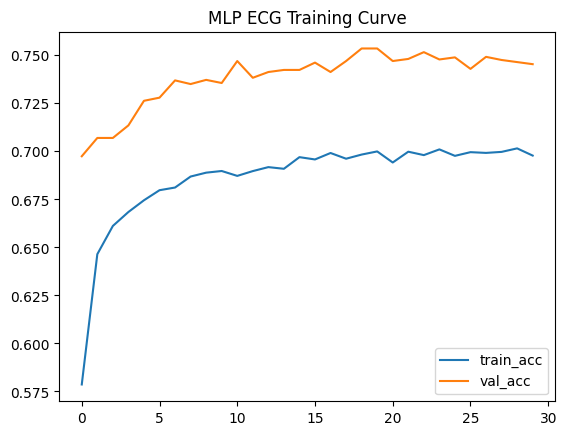

In [37]:
# === 构建模型 ===
mlp = build_mlp_ecg(X_tr.shape[1], num_classes=5)

# === 编译 ===
mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === 回调函数 ===
cb = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# === 训练 ===
history = mlp.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    class_weight=None,
    callbacks=cb,
    verbose=1
)

# === 可选：绘制训练曲线 ===
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('MLP ECG Training Curve')
plt.show()


原训练集分布： {0: 72470, 1: 2223, 2: 5788, 3: 641, 4: 6431}
τ=0.75 total_acc=0.6911, gated=10.1% of samples
τ=0.78 total_acc=0.6911, gated=10.1% of samples
τ=0.79 total_acc=0.6911, gated=10.1% of samples
τ=0.80 total_acc=0.6911, gated=10.1% of samples
τ=0.81 total_acc=0.6911, gated=10.1% of samples
τ=0.85 total_acc=0.6911, gated=10.1% of samples
τ=0.90 total_acc=0.6911, gated=10.1% of samples
原训练集大小: 87553
筛后训练集大小: 24162
筛后类别分布: {0: 9079, 1: 2223, 2: 5788, 3: 641, 4: 6431}
删除 3 类后类别分布： {0: 9079, 1: 2223, 2: 5788, 3: 6431}
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5900 - loss: 1.0262 - val_accuracy: 0.7008 - val_loss: 0.8549 - learning_rate: 3.0000e-04
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6327 - loss: 0.8728 - val_accuracy: 0.7127 - val_loss: 0.7892 - learning_rate: 3.0000e-04
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6425 - loss: 0.8363 - val_accuracy: 0.6962 - val_loss: 0.7955 - learning_rate: 3.0000e-04
Epoch 4/10

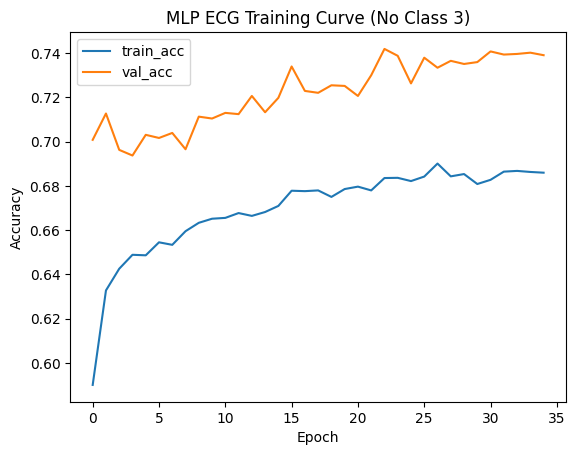

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models

# ==========================
# 1️⃣ 读取数据
# ==========================
mitbih_train = pd.read_csv("../data/ecg_category/mitbih_train.csv")
mitbih_test = pd.read_csv("../data/ecg_category/mitbih_test.csv")

X_mitbih_train, y_mitbih_train = mitbih_train.iloc[:, :-1].values, mitbih_train.iloc[:, -1].astype(int).values
X_mitbih_test, y_mitbih_test = mitbih_test.iloc[:, :-1].values, mitbih_test.iloc[:, -1].astype(int).values

print("原训练集分布：", dict(zip(*np.unique(y_mitbih_train, return_counts=True))))

# ==========================
# 2️⃣ 决策树筛“易例0类”
# ==========================
tree = DecisionTreeClassifier(
    max_depth=21,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42
)
tree.fit(X_mitbih_train, y_mitbih_train)
p0 = tree.predict_proba(X_mitbih_train)[:, 0]

# taus = [0.55, 0.58, 0.59, 0.60, 0.61, 0.65, 0.70] # 筛选阈值，可调 
taus = [0.75, 0.78, 0.79, 0.80, 0.81, 0.85, 0.90] # 筛选阈值，可调 
for t in taus:
    y_pred_cascade, gate = predict_cascade_on(X_val, tau=t) 
    acc = accuracy_score(y_val, y_pred_cascade) 
    print(f"τ={t:.2f} total_acc={acc:.4f}, gated={(gate.mean()*100):.1f}% of samples")

X_train_hard = X_mitbih_train[keep_mask]
y_train_hard = y_mitbih_train[keep_mask]

print("原训练集大小:", len(y_mitbih_train))
print("筛后训练集大小:", len(y_train_hard))
print("筛后类别分布:", dict(zip(*np.unique(y_train_hard, return_counts=True))))

# ==========================
# 🚫 2.5️⃣ 删除 3 类样本
# ==========================
mask_no3 = y_train_hard != 3
X_train_hard = X_train_hard[mask_no3]
y_train_hard = y_train_hard[mask_no3]

mask_no3_val = y_mitbih_test != 3
X_mitbih_test = X_mitbih_test[mask_no3_val]
y_mitbih_test = y_mitbih_test[mask_no3_val]

# 重新映射标签为连续的 0-3（原0,1,2,4）
mapping = {0:0, 1:1, 2:2, 4:3}
y_train_hard = np.array([mapping[y] for y in y_train_hard])
y_mitbih_test = np.array([mapping[y] for y in y_mitbih_test])

print("删除 3 类后类别分布：", dict(zip(*np.unique(y_train_hard, return_counts=True))))

# ==========================
# 3️⃣ 划分验证集 + 标准化
# ==========================
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_hard, y_train_hard,
    test_size=0.15,
    random_state=42,
    stratify=y_train_hard
)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)
X_mitbih_test = scaler.transform(X_mitbih_test)

# ==========================
# 4️⃣ 定义优化版 MLP 模型（4类输出）
# ==========================
def build_mlp_ecg(input_length, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_length,)),

        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

mlp = build_mlp_ecg(X_tr.shape[1], num_classes=4)  # 注意这里变成 4 类

mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cb = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# ==========================
# 5️⃣ 训练（可以保留过采样）
# ==========================
def oversample_class(X, y, cls, target):
    idx = np.where(y == cls)[0]
    if len(idx) < target:
        extra = np.random.choice(idx, target - len(idx), replace=True)
        X = np.concatenate([X, X[extra]], axis=0)
        y = np.concatenate([y, y[extra]], axis=0)
    return X, y

X_tr_bal, y_tr_bal = X_tr, y_tr
for c, tgt in [(1, 3000), (2, 3000)]:
    X_tr_bal, y_tr_bal = oversample_class(X_tr_bal, y_tr_bal, c, tgt)

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_tr_bal), y=y_tr_bal)
cls_w = {i:w for i,w in enumerate(cw)}

history = mlp.fit(
    X_tr_bal, y_tr_bal,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    class_weight=cls_w,
    callbacks=cb,
    verbose=1
)

# ==========================
# 6️⃣ 验证与可视化
# ==========================
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP ECG Training Curve (No Class 3)')
plt.show()


In [55]:
def predict_cascade_on(X, tau=0.98):
    p0 = tree.predict_proba(X)[:, 0]
    gate = (p0 >= tau)              # 高置信0类交给树处理
    y_pred = np.empty(X.shape[0], dtype=int)
    idx = np.where(~gate)[0]        # 其余交给 MLP
    if len(idx) > 0:
        y_pred[idx] = np.argmax(mlp.predict(X[idx], verbose=0), axis=1)
    y_pred[gate] = 0
    return y_pred, gate


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_cascade, gate = predict_cascade_on(X_val, tau=0.98)
print("Cascade total accuracy:", accuracy_score(y_val, y_pred_cascade))
print(classification_report(y_val, y_pred_cascade))
print(confusion_matrix(y_val, y_pred_cascade))


Cascade total accuracy: 0.6982147917257013
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      1362
           1       0.46      0.69      0.55       334
           2       0.74      0.75      0.75       868
           3       0.89      0.70      0.79       965

    accuracy                           0.70      3529
   macro avg       0.69      0.70      0.69      3529
weighted avg       0.72      0.70      0.70      3529

[[903 242 166  51]
 [ 79 230  24   1]
 [156  30 653  29]
 [250   2  35 678]]
